In [1]:
from gurobipy import *
import numpy as np
from data import load_data, get_data
from visualization import get_index_params, initialize_plot, add_sub_plot, remove_subplot  

In [12]:
class FrankWolfe:
    def __init__(self, A, b, rho, n_iter, epsilon = 1e-2):
        self.A = A
        self.b = b
        self.x_k = np.zeros((A.shape[1], 1))
        self.rho = rho
        self.k = 1
        self.n_iter = n_iter
        self.f_value = 0
        self.error_relativo = 0 
        self.norma_sol = 0
        self.error_list = []
        
        # epsilon representa a la tolerancia para considerar elementos nulos en la solución final x_k
        self.epsilon = epsilon  
        
    def get_alpha(self, k):
        return 2/(2 + k)
    
    def get_x(self, x_k, y, k):
        alpha = self.get_alpha(k)
        return x_k + alpha * (y - x_k)
    
    def error(self, A, b, x_k):
        return A.dot(x_k) - b
    
    def relative_error(self, A, b, x_k):
        e = self.error(A, b, x_k)
        return np.linalg.norm(e)/np.linalg.norm(b)
    
    
    def obj_function(self, A, b, x_k):
        e = self.error(A, b, x_k)
        return 0.5 * e.T.dot(e)

    
    def gradient(self, A, b, x_k):
        err = self.error(A, b, x_k)
        return A.T.dot(err)
    
    
    def update_info(self):
        self.f_value = self.obj_function(self.A, self.b, self.x_k)
        err = self.relative_error(self.A, self.b, self.x_k)
        self.error_relativo = err
        self.norma_sol = np.linalg.norm(self.x_k, 1)
        self.error_list.append(err)

    def solve_linear_problem(self, grad, rho):
        model = Model('P.L iteración k')
        
        # diccionario de variables a utilizar
        y = dict()
        z = dict()
        
        # Creamos las variables
        for i in range(grad.shape[0]):
            y[i] = model.addVar(vtype=GRB.CONTINUOUS, name="y_{}".format(i))
            z[i] = model.addVar(vtype=GRB.CONTINUOUS, name="z_{}".format(i))
        
        # Definimos función objetivo
        model.setObjective(quicksum(grad[i,0] * y[i] for i in range(grad.shape[0])), GRB.MINIMIZE)
        
        # R1) representa a la norma 1 de los y (escrito en términos de z)
        model.addConstr(quicksum(z[i] for i in range(grad.shape[0])) <= rho)
        
        # R2) z debe ser igual al valor absoluto de y
        for i in range(grad.shape[0]):
            model.addGenConstrAbs(z[i], y[i], "absconstr")
        
        model.setParam('OutputFlag', 0)
        model.optimize()
        
        # Retornamos variable y como vector
        y = np.array([y[i].X for i in range(grad.shape[0])])
        return y.reshape(y.shape[0], 1)


    def algorithm(self):
        while self.k < self.n_iter:
            grad = self.gradient(self.A, self.b, self.x_k)
            y = self.solve_linear_problem(grad, self.rho)
            self.x_k = self.get_x(self.x_k, y, self.k)
            self.update_info()
            self.k += 1
    
    def __str__(self):
        x = self.x_k
        m = np.where(abs(x) < abs(x).max() * self.epsilon, 0, abs(x))

        cadena1 = f"\n\n********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = {self.rho} ********* \n\n"
        cadena2 = "ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 \n"
        cadena3 = "%12.6f %12.6f %12.6f %12.6f" % (int(self.k), self.f_value, self.error_relativo, self.norma_sol) + '\n'
        cadena4 = 'Elementos no nulos: ' + str(np.where(abs(x) < abs(x).max() * self.epsilon, 0, 1).sum()) + '\n'
        cadena5 = 'Valor máximo xsol: ' + str(m.max()) + '\n'
        cadena6 = 'Valor mínimo xsol: ' + str(np.min(m[np.nonzero(m)])) + '\n'
        
        return cadena1 + cadena2 + cadena3 + cadena4 + cadena5 + cadena6

In [6]:
# Cargamos datos

df = load_data('data.xlsx')
A, b = get_data(df)



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 3 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  500.000000     4.850942     0.335081     2.999976
Elementos no nulos: 96
Valor máximo xsol: 0.14277844311377255
Valor mínimo xsol: 0.0014371257485029942



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 4 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  500.000000     1.452469     0.183354     3.999968
Elementos no nulos: 153
Valor máximo xsol: 0.10829540918163673
Valor mínimo xsol: 0.0013093812375249494



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 5 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  500.000000     0.598881     0.117735     4.999960
Elementos no nulos: 215
Valor máximo xsol: 0.09225548902195613
Valor mínimo xsol: 0.00095808383233533



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 6 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  500.000000     0.599100   

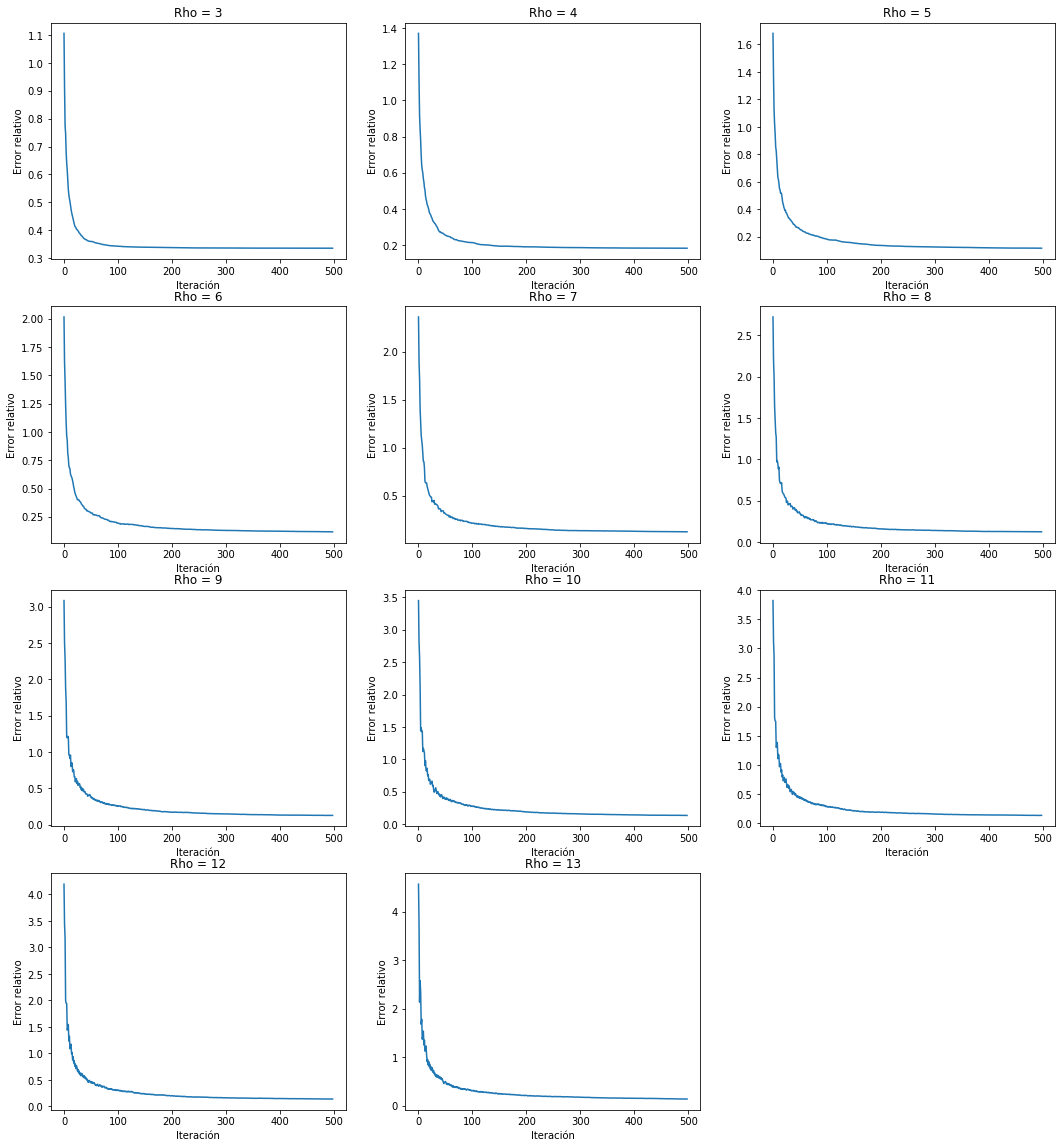

In [14]:
# Corremos el algoritmo para diferentes rhos.

rhos = np.arange(3, 14)

fig, axs, index = initialize_plot(y_size = 18, x_size = 20, n_sub_plots = len(rhos), n_columns = 3)
x = np.arange(499)

contador = 0
for rho in rhos:
    fwolfe = FrankWolfe(A, b, rho, 500)
    fwolfe.algorithm()
    print(fwolfe)
    i, j = index[contador]
    add_sub_plot(axs, x, fwolfe.error_list, i, j, title = f'Rho = {rho}', x_label = 'Iteración', y_label = 'Error relativo')
    contador +=1


#### Uno tendería a pensar que el mmétodo converge muy rápido a partir de las curvas. Sin embargo esto no es cierto, parece ser así debido a la gran diferencia numérica entre el error relativo en las primeras iteraciones del algoritmo y las siguientes, perdiendo la forma de la cirva para iteraciones más avanzadas. Debido a esto ejecutamos el mismo elagoritmo con respecto a los mismo rhos pero en las gráficas solo mostraremos las iteraciones de la 25 en adelante para apreciar realmente la curva en errores relativos de iteraciones más avanzadas



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 3 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  600.000000     4.848887     0.335010     2.999983
Elementos no nulos: 97
Valor máximo xsol: 0.13615640599001672
Valor mínimo xsol: 0.0015640599001663915



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 4 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  600.000000     1.443930     0.182814     3.999978
Elementos no nulos: 157
Valor máximo xsol: 0.1241708264004437
Valor mínimo xsol: 0.001353300055463119



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 5 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  600.000000     0.585389     0.116402     4.999972
Elementos no nulos: 230
Valor máximo xsol: 0.08915696062118694
Valor mínimo xsol: 0.000970604547975598



********** MÉTODO FRANK - WOLFE ÚLTIMA ITERACIÓN CON RO = 6 ********* 

ITERACION     VALOR OBJ      ERROR AJUSTE  ||x||_1 
  600.000000     0.580684    

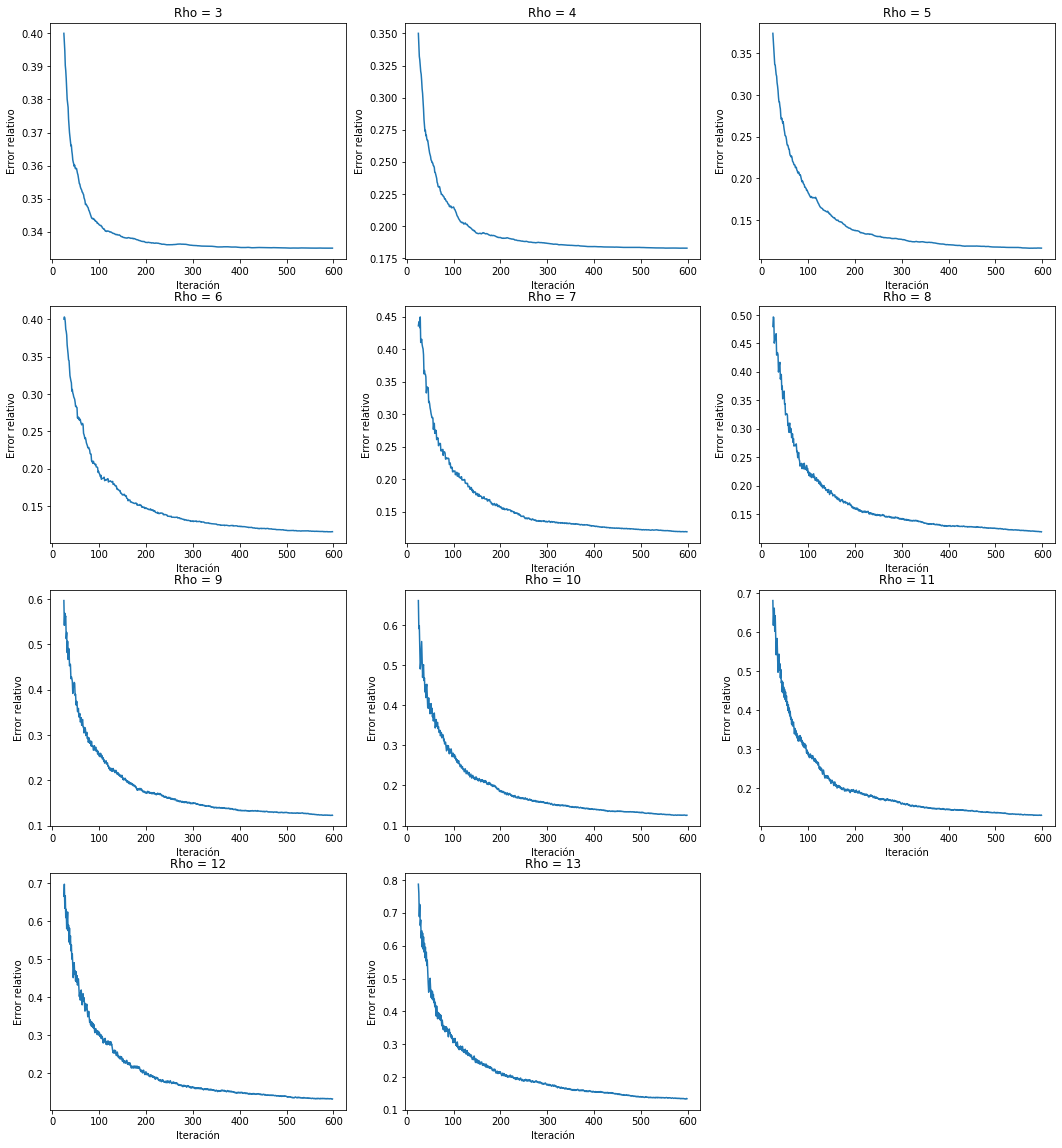

In [16]:
# Corremos el algoritmo para diferentes rhos.

rhos = np.arange(3, 14)

fig, axs, index = initialize_plot(y_size = 18, x_size = 20, n_sub_plots = len(rhos), n_columns = 3)
x = np.arange(599)

contador = 0
for rho in rhos:
    fwolfe = FrankWolfe(A, b, rho, 600)
    fwolfe.algorithm()
    print(fwolfe)
    i, j = index[contador]
    add_sub_plot(axs, x[25:], fwolfe.error_list[25:], i, j, title = f'Rho = {rho}', x_label = 'Iteración', y_label = 'Error relativo')
    contador +=1